In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from resources.utils import conf_matrix, read_mat

# default plot settings
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['axes.facecolor'] = 'lightskyblue'
plt.rcParams['axes.titlepad'] = 35.0
rng = np.random.RandomState(42)

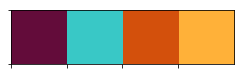

In [2]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)
def plot_data(dframe,x='x', y='y',col='label'):
    sns.lmplot(data=dframe, x=x, y=y, col=col, 
                   fit_reg=False, legend=True, legend_out=True)
    

In [8]:
def model_fitting(df, xidx, ylabel,test_size, random_state, model, model_name="iforest"):
    Data = df.iloc[:,xidx].values
    Target = df[ylabel].values
    X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=test_size, random_state=random_state, stratify=Target)
    print('Training Features Shape:', X_train.shape)
    print('Training Labels Shape:', y_train.shape)
    print('Testing Features Shape:', X_test.shape)
    print('Testing Labels Shape:', y_test.shape) 
    
    if (model_name=="iforest"):
        model.fit(X_train)
    else:
        model.fit(X_train,y_train)
    
    return ((X_test, y_test), model)

In [4]:
def plot_prep(data_splits, model, actual_inlier, model_inlier, model_name="model"):
    X_test, y_test = data_splits
    y_pred = model.predict(X_test)    
    y_test_new = []
    for yt in y_test.tolist():
        if yt==actual_inlier:
            y_test_new.append('Good')
        else:
            y_test_new.append('Bad')
            
    y_pred_new = []
    for yt in y_pred.tolist():
        if yt==model_inlier:
            y_pred_new.append('Good')
        else:
            y_pred_new.append('Bad')
        
    data = np.stack((X_test[:, 2], X_test[:,1], y_test_new, y_pred_new)).T
    new_df = pd.DataFrame(data, columns=['x', 'y', '{}.actual'.format(model_name), '{}.predicted'.format(model_name)])
    new_df['x'] = new_df['x'].astype('float')
    new_df['y'] = new_df['y'].astype('float')
    return (new_df, 'x', 'y', ('{}.actual'.format(model_name), '{}.predicted'.format(model_name)))

In [5]:
def conf_prep(df, model_name):
    y_act = df['{}.actual'.format(model_name)].values.tolist()
    y_pred = df['{}.predicted'.format(model_name)].values.tolist()
    
    y_act = [0 if x=='Good' else 1 for x in y_act]
    y_pred = [0 if x=='Good' else 1 for x in y_pred]
    return (y_act, y_pred, [0,1])

**Case - Dataset #1**<br/>
The original Statlog (Landsat Satellite) dataset from UCI machine learning repository is a multi-class classification dataset. Here, the training and test data are combined. The smallest three classes, i.e. 2, 4, 5 are combined to form the outliers class, while all the other classes are combined to form an inlier class.

*Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)*

In [28]:
filepath = 'resources/anomaly_datasets/satellite.mat'
df_satellite = read_mat(filepath)
df_satellite.head()
features = range(0,df_satellite.shape[1]-1)

Training Features Shape: (5148, 36)
Training Labels Shape: (5148,)
Testing Features Shape: (1287, 36)
Testing Labels Shape: (1287,)


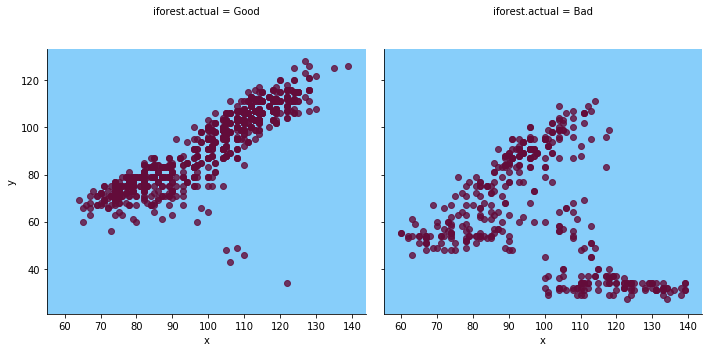

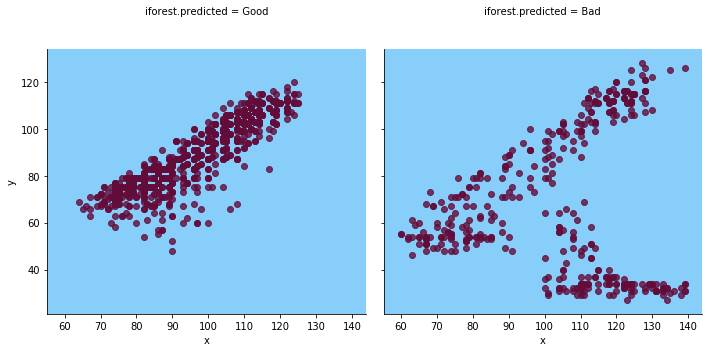

In [30]:
'''Initialize Models Here'''
clf1 = IsolationForest(behaviour='new', max_samples='auto',
                          random_state=rng, contamination=0.3)    



data_splits, clf1_trained = model_fitting(df_satellite, features, 'label', 0.20, rng, clf1, model_name="iforest")

df1_iso, plot_x, plot_y, cols = plot_prep(data_splits,clf1_trained, 0, 1, "iforest")
plot_data(df1_iso, x=plot_x, y=plot_y, col=cols[0])
plot_data(df1_iso, x=plot_x, y=plot_y, col=cols[1])

Training Features Shape: (5148, 36)
Training Labels Shape: (5148,)
Testing Features Shape: (1287, 36)
Testing Labels Shape: (1287,)


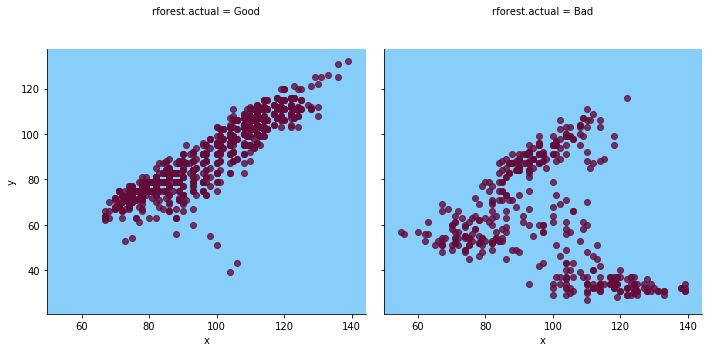

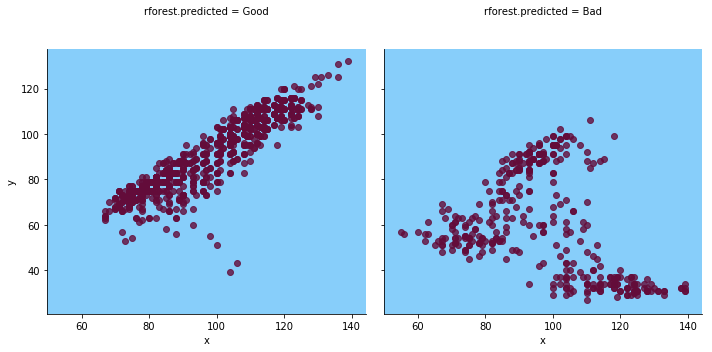

In [31]:
rfc1 = RandomForestClassifier(n_estimators=100, random_state=rng, max_features=1.,
                                 class_weight='balanced', n_jobs=-1)
data_splits, rfc1_trained = model_fitting(df_satellite, features, 'label', 0.20, rng, rfc1, model_name="rforest")
df1_rf, plot_x, plot_y, cols = plot_prep(data_splits,rfc1_trained, 0, 0, "rforest")
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[1])

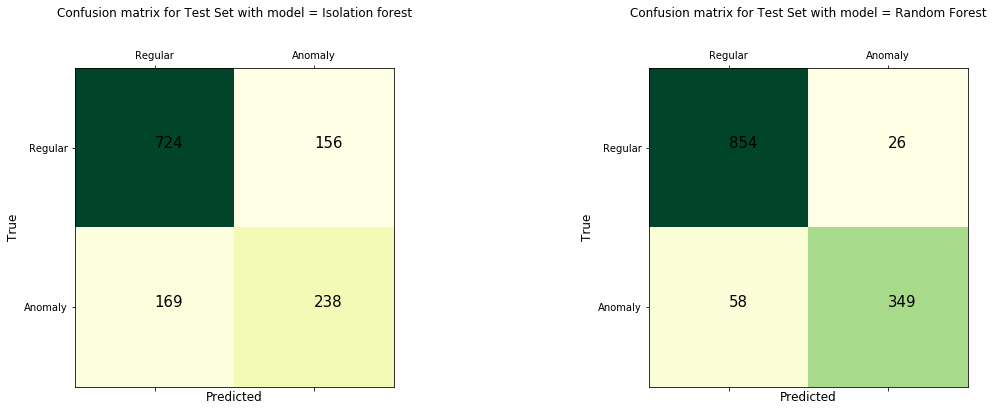

In [32]:
test1_iso, pred1_iso, labels1_iso = conf_prep(df1_iso, "iforest")
test1_rf, pred1_rf, labels1_ref = conf_prep(df1_rf, "rforest")
    
fig = plt.figure(figsize=(16,12))
conf_matrix(test1_iso, pred1_iso, fig, labels=labels1_iso, z=1 )
conf_matrix(test1_rf, pred1_rf, fig, labels= labels1_ref, model_name="Random Forest", z=2)
fig.subplots_adjust(wspace=0.8)
plt.show()

**Case - Dataset #2**<br/>
A very imbalanced dataset for ICU discharge of patients. A bad discharge is when the patient had to be readmitted within 90 days of discharge from the ICU. A very few cases of bad discharge are present in the dataset which indicates that such cases can simply be anomalies.

*Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)*

In [33]:
'''Isolation and Random Forest on really bad dataset'''
path = 'resources/pacemed/'
df_icu = pd.read_csv(path+'cleaned.csv',index_col=None, sep=',')
df_icu['bad_discharge'] = df_icu['bad_discharge'].astype('int')
df_icu.head()
features = range(1,df_icu.shape[1]-1)

Training Features Shape: (1119, 5)
Training Labels Shape: (1119,)
Testing Features Shape: (280, 5)
Testing Labels Shape: (280,)


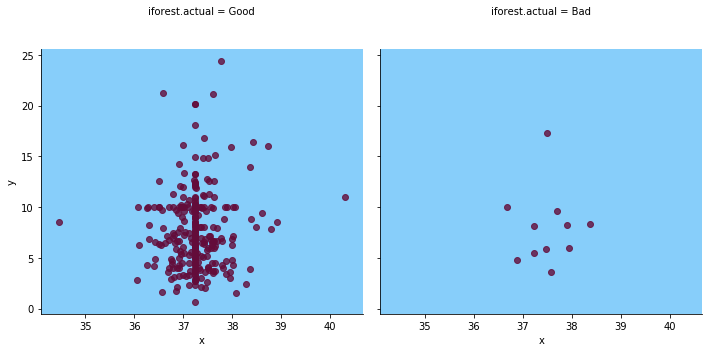

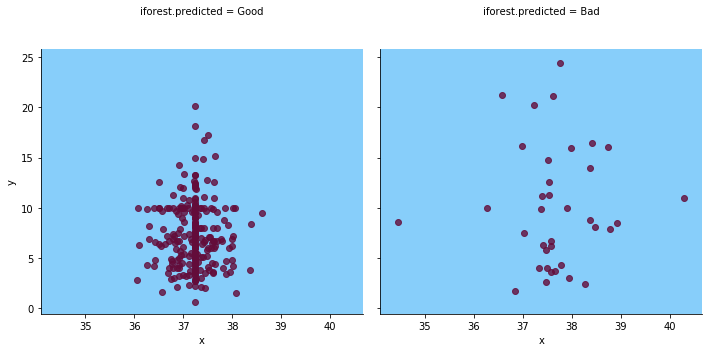

In [13]:
'''Initialize Models Here'''
clf2 = IsolationForest(behaviour='new', max_samples='auto',
                          random_state=rng, contamination=0.1)

data_splits, clf2_trained = model_fitting(df_icu, features, 'bad_discharge', 0.20, rng, clf2, model_name="iforest")

df2_iso, plot_x, plot_y, cols = plot_prep(data_splits,clf2_trained, 0, 1, "iforest")
plot_data(df2_iso, x=plot_x, y=plot_y, col=cols[0])
plot_data(df2_iso, x=plot_x, y=plot_y, col=cols[1])

Training Features Shape: (1119, 5)
Training Labels Shape: (1119,)
Testing Features Shape: (280, 5)
Testing Labels Shape: (280,)


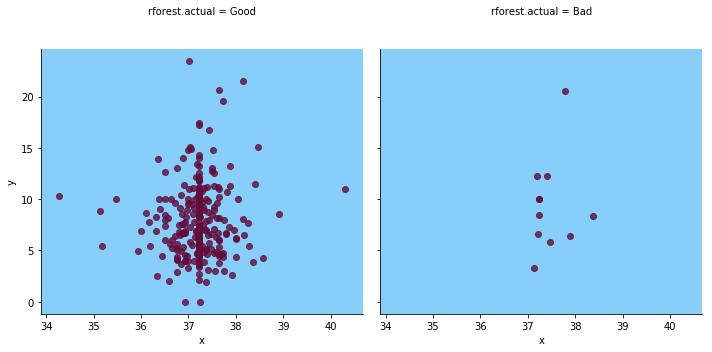

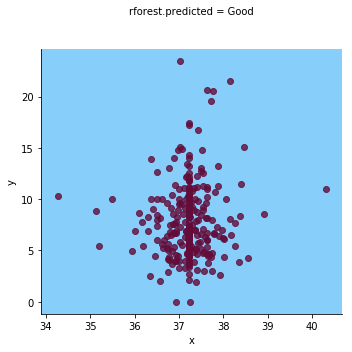

In [34]:
rfc2 = RandomForestClassifier(n_estimators=100, random_state=rng, max_features="auto",
                                 class_weight='balanced', n_jobs=-1)

data_splits, rfc2_trained = model_fitting(df_icu, features, 'bad_discharge', 0.20, rng, rfc2, model_name="rforest")

df2_rf, plot_x, plot_y, cols = plot_prep(data_splits,rfc2_trained, 0, 0, "rforest")
plot_data(df2_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df2_rf, x=plot_x, y=plot_y, col=cols[1])

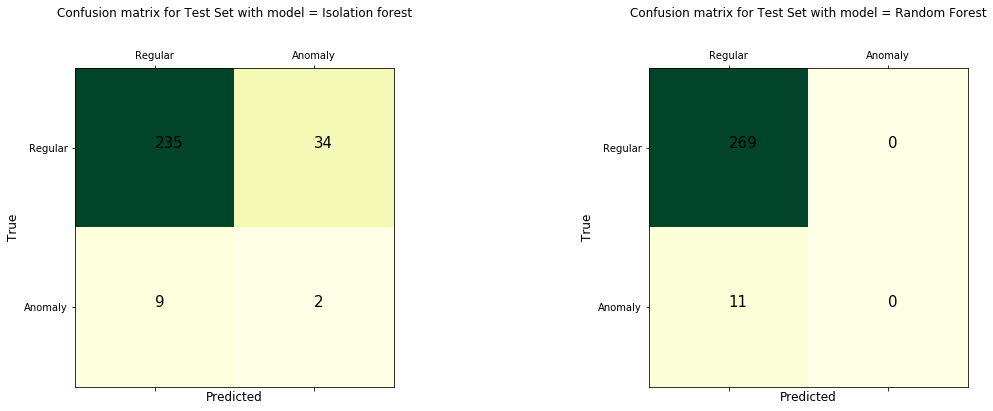

In [35]:
test2_iso, pred2_iso, labels2_iso = conf_prep(df2_iso, "iforest")
test2_rf, pred2_rf, labels2_ref = conf_prep(df2_rf, "rforest")
    
fig = plt.figure(figsize=(16,12))
conf_matrix(test2_iso, pred2_iso, fig, labels=labels2_iso, z=1 )
conf_matrix(test2_rf, pred2_rf, fig, labels= labels2_ref, model_name="Random Forest", z=2)
fig.subplots_adjust(wspace=0.8)
plt.show()

**Case - Dataset #3**<br/>
The original ForestCover/Covertype dataset from UCI machine learning repository is a multiclass classification dataset. It is used in predicting forest cover type from cartographic variables only (no remotely sensed data). This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. This dataset has 54 attributes (10 quantitative variables, 4 binary wilderness areas and 40 binary soil type variables). Here, outlier detection dataset is created using only 10 quantitative attributes. Instances from class 2 are considered as normal points and instances from class 4 are anomalies. The anomalies ratio is 0.9%. Instances from the other classes are omitted.

*Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)*




In [40]:
filepath = 'resources/anomaly_datasets/cover.mat'
df_cover = read_mat(filepath)
df_cover.head()
features = range(0,df_cover.shape[1]-1)

Training Features Shape: (228838, 10)
Training Labels Shape: (228838,)
Testing Features Shape: (57210, 10)
Testing Labels Shape: (57210,)


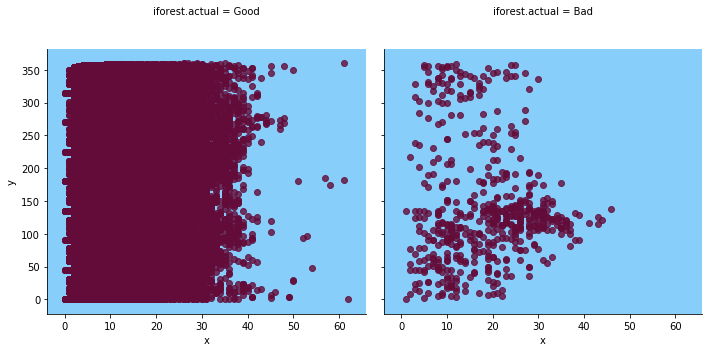

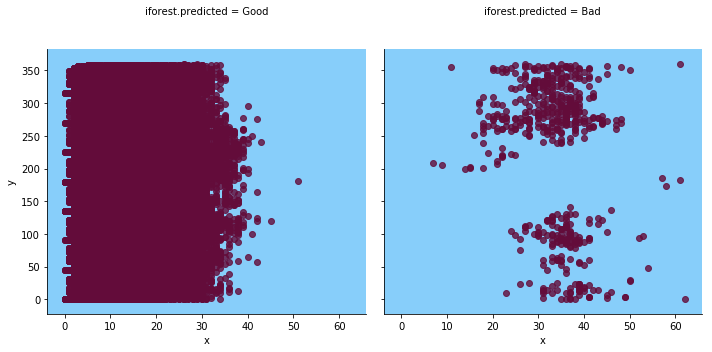

In [41]:
'''Initialize Models Here'''
clf3 = IsolationForest(n_estimators=100, behaviour='new', max_samples='auto',
                          random_state=rng, contamination=0.0092)
    



data_splits, clf3_trained = model_fitting(df_cover, features, 'label', 0.20, rng, clf3, model_name="iforest")

df3_iso, plot_x, plot_y, cols = plot_prep(data_splits,clf3_trained, 0, 1, "iforest")
plot_data(df3_iso, x=plot_x, y=plot_y, col=cols[0])
plot_data(df3_iso, x=plot_x, y=plot_y, col=cols[1])


Training Features Shape: (228838, 10)
Training Labels Shape: (228838,)
Testing Features Shape: (57210, 10)
Testing Labels Shape: (57210,)


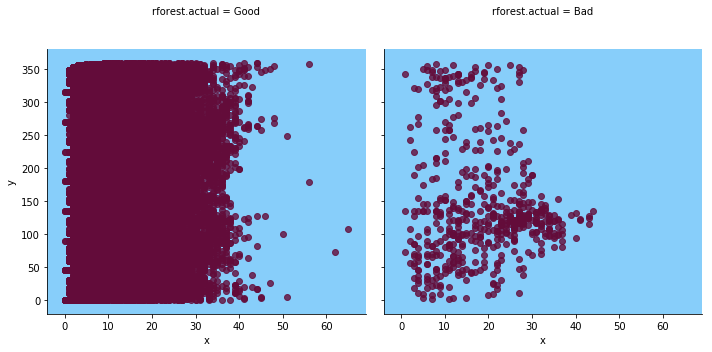

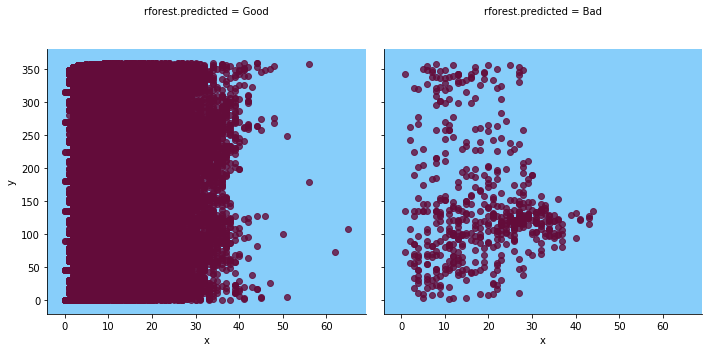

In [42]:
rfc3 = RandomForestClassifier(n_estimators=100, random_state=rng, max_features='auto',
                                 class_weight='balanced', n_jobs=-1)

data_splits, rfc3_trained = model_fitting(df_cover, features, 'label', 0.20, rng, rfc3, model_name="rforest")

df3_rf, plot_x, plot_y, cols = plot_prep(data_splits,rfc3_trained, 0, 0, "rforest")
plot_data(df3_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df3_rf, x=plot_x, y=plot_y, col=cols[1])

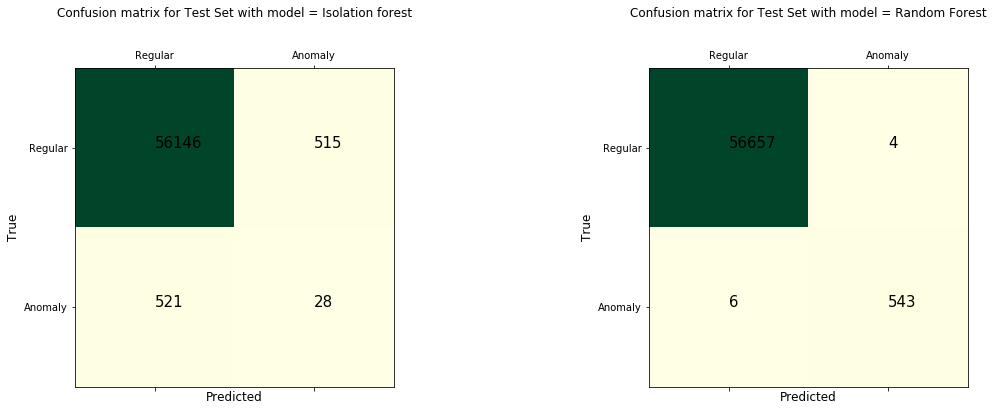

In [43]:
test3_iso, pred3_iso, labels3_iso = conf_prep(df3_iso, "iforest")
test3_rf, pred3_rf, labels3_ref = conf_prep(df3_rf, "rforest")
    
fig = plt.figure(figsize=(16,12))
conf_matrix(test3_iso, pred3_iso, fig, labels=labels3_iso, z=1 )
conf_matrix(test3_rf, pred3_rf, fig, labels= labels3_ref, model_name="Random Forest", z=2)
fig.subplots_adjust(wspace=0.8)
plt.show()